# Aztec G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

## Perform Simulation

In [2]:
from aztec_gddt.experiment import test_run
from aztec_gddt.scenario_experiments import scenario_group_2_experiment


exp = scenario_group_2_experiment()


from cadCAD.engine import ExecutionContext, ExecutionMode, Executor


_exec_mode = ExecutionMode().single_mode
exec_context = ExecutionContext(_exec_mode, additional_objs={'deepcopy_off': True})
executor = Executor(exec_context=exec_context, configs=exp.configs, supress_print=False)

# Execute the cadCAD experiment
(records, tensor_field, _) = executor.execute()

# Parse the output as a pandas DataFrame
df = pd.DataFrame(records)

# Drop substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = first_ind | last_ind
df = df.loc[inds_to_drop].drop(columns=['substep'])


# Assign Params
M_dict = exp.configs[0].sim_config['M']
params_set = set(M_dict.keys())

selected_params = params_set
# Attribute parameters to each row*

from cadCAD.tools.execution.easy_run import select_config_M_dict # type: ignore
params_dict = select_config_M_dict(exp.configs, 0, selected_params)

# Handles all cases of parameter types including list
for key, value in params_dict.items():
    df[key] = df.apply(lambda _: value, axis=1)

for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    params_dict = select_config_M_dict(exp.configs, i, selected_params)
    for key, value in params_dict.items():
        df.loc[n_df.index, key] = df.loc[n_df.index].apply(
            lambda _: value, axis=1)
        

sim_df = df


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 2000, 88, 30, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (1000, 44, 18, 32)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (1000, 44, 12, 32)


Initializing configurations:   0%|          | 0/30 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/180030 [00:00<?, ?it/s]

Total execution time: 10.30s


## Visualization over Model Features

In [3]:
sim_df.head(5)

,timestep,l1_blocks_passed,delta_l1_blocks,l2_blocks_passed,agents,validator_set,current_epoch,last_epoch,last_reward_time_in_l1,last_reward,...,ORACLE_UPDATE_FREQUENCY_E,JUICE_PER_WEI_MEAN,JUICE_PER_WEI_STD,MAX_FEE_INFLATION_PER_BLOCK,MAX_FEE_INFLATION_RELATIVE_MEAN,MAX_FEE_INFLATION_RELATIVE_STD,JUICE_PER_MANA_MEAN,JUICE_PER_MANA_STD,PROVING_COST_MODIFIER_INITIAL_C,FEE_JUICE_PRICE_MODIFIER_INITIAL_C
0,0,0,0,0,"[Agent(uuid='0', commitment_bond=1.14173513429...",{},"Epoch(init_time_in_l1=-999, validators=[], slo...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.01,0.5,0.3,10.0,1.0,100,1.0
6,1,1,1,1,"[Agent(uuid='0', commitment_bond=1.14173513429...",{},"Epoch(init_time_in_l1=1, validators=['200', '7...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.01,0.5,0.3,10.0,1.0,100,1.0
12,2,2,1,1,"[Agent(uuid='0', commitment_bond=1.14173513429...",{},"Epoch(init_time_in_l1=1, validators=['200', '7...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.01,0.5,0.3,10.0,1.0,100,1.0
18,3,3,1,1,"[Agent(uuid='0', commitment_bond=1.14173513429...",{},"Epoch(init_time_in_l1=1, validators=['200', '7...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.01,0.5,0.3,10.0,1.0,100,1.0
24,4,4,1,2,"[Agent(uuid='0', commitment_bond=1.14173513429...",{},"Epoch(init_time_in_l1=1, validators=['200', '7...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,15000.0,...,0.5,5.0,2.0,0.01,0.5,0.3,10.0,1.0,100,1.0


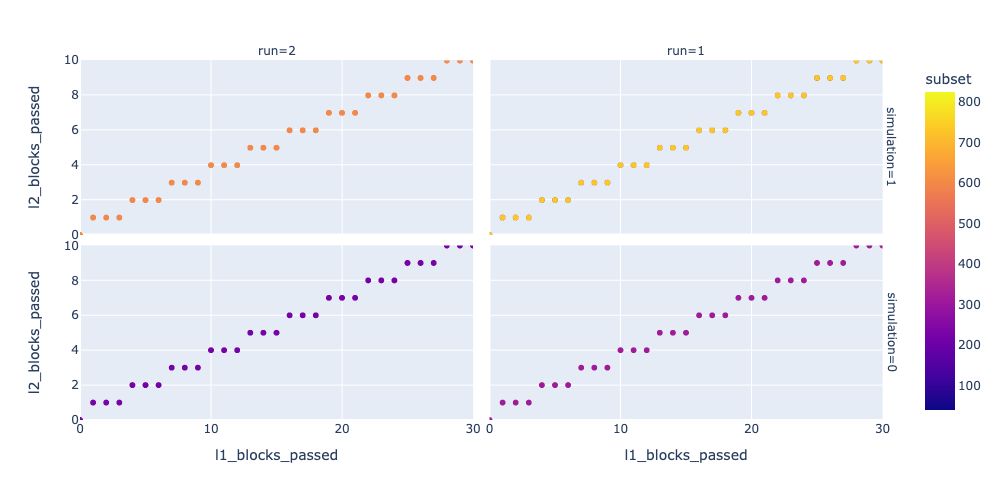

In [4]:
fig = px.scatter(sim_df.reset_index(), x='l1_blocks_passed', y='l2_blocks_passed', color='subset', facet_col='run', facet_row='simulation')
fig.update_layout(yaxis_range=[0, 10], xaxis_range=[0,  10 * 3], width=1000, height=500)
fig.show()

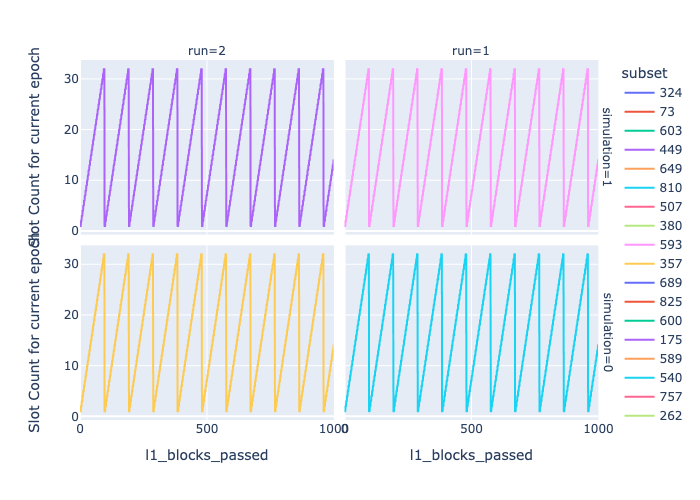

In [5]:
y = sim_df.current_epoch.map(lambda x: len(x.slots))

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Slot Count for current epoch'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

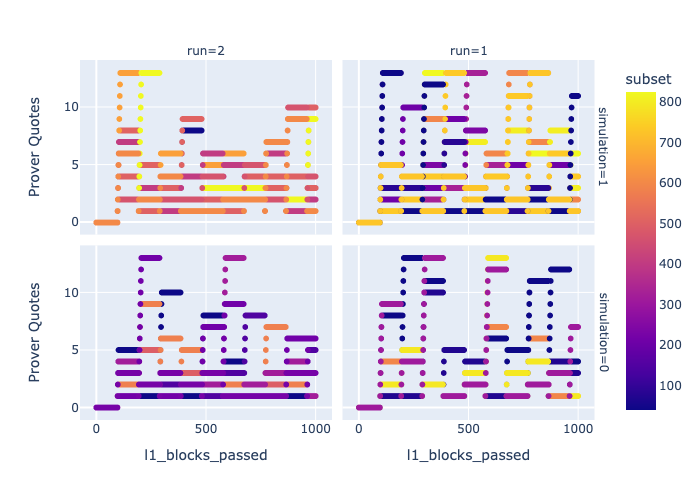

In [6]:
y = sim_df.last_epoch.map(lambda x: len(x.prover_quotes))

fig = px.scatter(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Prover Quotes'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

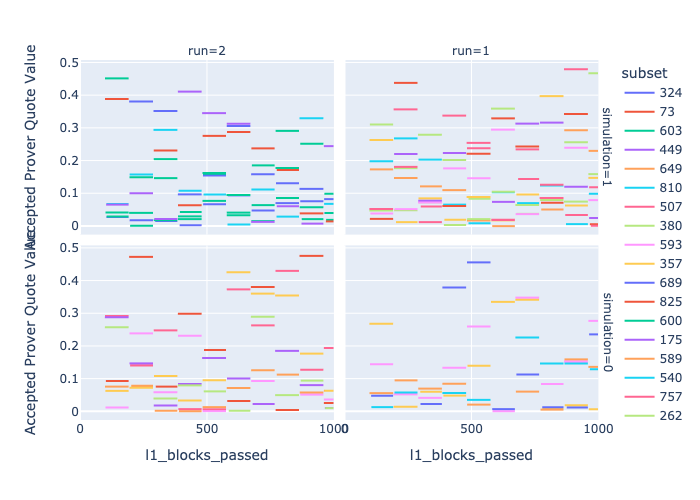

In [7]:
y = sim_df.last_epoch.map(lambda x: x.accepted_prover_quote)

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Accepted Prover Quote Value'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

## Visualization over PSUU Per-Trajectory Metrics

In [8]:
from aztec_gddt.psuu.metrics import *

In [9]:
for label, fn in PER_TRAJECTORY_METRICS.items():
    print(f"{label}: {fn.__name__}")
    print(sim_df.reset_index().groupby(['simulation', 'subset', 'run']).apply(fn, include_groups=False))
    print("---")

T-M1: relative_volatility_across_time
simulation  subset  run
0           39      1      0.027489
            70      1      0.003067
            73      2      0.044704
            175     2      0.015563
            239     2      0.039194
            249     2      0.004562
            309     1      0.026727
            339     2      0.003436
            507     2      0.009977
            589     2      0.022776
            593     1      0.027425
            793     1      0.060361
1           230     1      0.006535
            262     1      0.035041
            324     2      0.033656
            357     1      0.032182
            380     1      0.104699
            449     1      0.053540
            540     2      0.015355
            579     2      0.004771
            600     2      0.024067
            603     2      0.030190
            649     1      0.019824
            658     2      0.015769
            689     2      0.082594
            751     1      0.015496
  

In [10]:
for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():

    groups = list(sim_df.reset_index().groupby(['simulation']))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        print(f"{label}: {fn.__name__}")
        print(fn(dfs))
        print("---")    

TG-M1: <lambda>
0.006364374605404423
---
TG-M1: <lambda>
0.009563706036040431
---
TG-M2: <lambda>
35.5
---
TG-M2: <lambda>
20.5
---
TG-M3: <lambda>
2.0
---
TG-M3: <lambda>
1.5
---
TG-M4: <lambda>
0.9946069126770881
---
TG-M4: <lambda>
0.9955663997330664
---
TG-M5: <lambda>
nan
---
TG-M5: <lambda>
nan
---
TG-M6: <lambda>
0.0
---
TG-M6: <lambda>
0.0
---
TG-M7: <lambda>
1.0
---
TG-M7: <lambda>
1.0
---
TG-M8: <lambda>
nan
---
TG-M8: <lambda>
nan
---
TG-M9: <lambda>
nan
---
TG-M9: <lambda>
nan
---
TG-M10: <lambda>
nan
---
TG-M10: <lambda>
nan
---
TG-M11: <lambda>
nan
---
TG-M11: <lambda>
nan
---
TG-M12: <lambda>
nan
---
TG-M12: <lambda>
nan
---
TG-M13: <lambda>
nan
---
TG-M13: <lambda>
nan
---


In [11]:
control_params = [
        'MAX_FEE_INFLATION_PER_BLOCK',
        'RELATIVE_TARGET_MANA_PER_BLOCK',
        'MAXIMUM_MANA_PER_BLOCK',
        'MINIMUM_MULTIPLIER_CONGESTION',
        'UPDATE_FRACTION_CONGESTION',
        'OVERHEAD_MANA_PER_TX',
        'PROVING_COST_MODIFIER_INITIAL_C',
        'FEE_JUICE_PRICE_MODIFIER_INITIAL_C',
        'MAXIMUM_UPDATE_PERCENTAGE_C',
        ]

In [12]:
from aztec_gddt.psuu.metrics import *


for control_param in control_params:
    print(f"### {control_param} ###")
    groups = list(sim_df.reset_index().groupby([control_param]))

    for i, g in groups:
        print(f"{control_param} = {i}")
        for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():
            dfs = [el[1] for el in list(g.groupby(['simulation', 'subset', 'run']))]
            print(f"{label}={fn(dfs) :.3f}")
        print("---")

### MAX_FEE_INFLATION_PER_BLOCK ###
MAX_FEE_INFLATION_PER_BLOCK = (0.0,)
TG-M1=0.037
TG-M2=26.538
TG-M3=1.692
TG-M4=0.996
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
MAX_FEE_INFLATION_PER_BLOCK = (0.01,)
TG-M1=0.014
TG-M2=18.222
TG-M3=1.444
TG-M4=0.996
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
MAX_FEE_INFLATION_PER_BLOCK = (0.1,)
TG-M1=0.026
TG-M2=14.875
TG-M3=1.375
TG-M4=0.997
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
### RELATIVE_TARGET_MANA_PER_BLOCK ###
RELATIVE_TARGET_MANA_PER_BLOCK = (0.1,)
TG-M1=0.029
TG-M2=21.182
TG-M3=1.545
TG-M4=0.997
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M12=nan
TG-M13=nan
---
RELATIVE_TARGET_MANA_PER_BLOCK = (0.5,)
TG-M1=0.029
TG-M2=18.867
TG-M3=1.467
TG-M4=0.997
TG-M5=nan
TG-M6=0.000
TG-M7=1.000
TG-M8=nan
TG-M9=nan
TG-M10=nan
TG-M11=nan
TG-M